In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings('ignore')

In [2]:
symbol = "510300"
phi_val = 0.0001
base_path = f"output/{symbol}"
methods = ['arl', 'drl', 'glft', 'foic']

dfs = {}
for m in methods:
    path = f"{base_path}/{m}/backtest_{phi_val}.parquet"
    dfs[m] = pd.read_parquet(path)

print(f">>> Successfully loaded datasets for: {methods}")

>>> Successfully loaded datasets for: ['arl', 'drl', 'glft', 'foic']


## H1: Predictive Efficacy ##

Using Diebold-Mariano (DM) test to verify SGUs obtain better residual compared with trivial prediction significantly

In [3]:
def dm_test(actual, pred1, pred2, h=1, crit="MSE"):
    e1 = (actual - pred1)**2 if crit=="MSE" else abs(actual - pred1)
    e2 = (actual - pred2)**2 if crit=="MSE" else abs(actual - pred2)
    d = e1 - e2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    return dm_stat, p_value

In [4]:
df_arl = dfs['arl']
actual_mid_change = df_arl['mid'].shift(-1) - df_arl['mid']
pred_sgu = df_arl['s2_pred']
naive_pred = np.zeros_like(pred_sgu)
dm_stat, p_val = dm_test(actual_mid_change[:-1], pred_sgu[:-1], naive_pred[:-1])
print(f"H1 (DM Test): Statistic={dm_stat:.4f}, p-value={p_val:.4f}")

H1 (DM Test): Statistic=20.9560, p-value=0.0000


## H2: Execution Intensity ##

Using DW test to verify if DW differs from 2 signficantly, which indicates that execution reward exists autocorrelation.

In [5]:
dw_stat = durbin_watson(dfs['arl']['reward'])
print(f"H2: DW-Stat = {dw_stat:.4f}")

H2: DW-Stat = 1.2835


## H3: Comparative Superiority ##

Using Moving Block Bootstrap (MBB) for 500 samplings, calculating the 95% CI of Sharpe.

In [6]:
def get_mbb_sharpe(wealth_series, block_size=100, n_boot=500):
    """
    Calculate per-step Sharpe Ratio using Moving Block Bootstrap with safety checks.
    """
    returns = wealth_series.pct_change().dropna().values
    n = len(returns)
    
    if n <= block_size or n == 0:
        std = np.std(returns)
        sr = np.mean(returns) / std if std > 1e-9 else 0
        return sr, (sr, sr)

    boot_srs = []
    num_blocks = max(1, n // block_size)
    
    for _ in range(n_boot):
        max_start_idx = n - block_size
        indices = np.random.randint(0, max_start_idx + 1, size=num_blocks)
        
        resampled_list = [returns[i:i+block_size] for i in indices]
        
        if not resampled_list:
            boot_srs.append(0)
            continue
            
        resampled = np.concatenate(resampled_list)
        
        ret_std = np.std(resampled)
        if ret_std > 1e-9:
            sr = np.mean(resampled) / ret_std
        else:
            sr = 0
        boot_srs.append(sr)
        
    return np.mean(boot_srs), np.percentile(boot_srs, [2.5, 97.5])

In [7]:
print("H3: 95% CI of Per-Step Sharpe:")
for m in methods:
    if m in dfs and not dfs[m].empty:
        try:
            mean_sr, ci = get_mbb_sharpe(dfs[m]['wealth'], block_size=100)
            print(f"  - {m.upper():<4}: {mean_sr:>8.6f} | CI: [{ci[0]:>8.6f}, {ci[1]:>8.6f}]")
        except Exception as e:
            print(f"  - {m.upper():<4}: Error processing data - {e}")
    else:
        print(f"  - {m.upper():<4}: No data found in DataFrame.")

H3: 95% CI of Per-Step Sharpe:
  - ARL : 0.398143 | CI: [0.000000, 0.688657]
  - DRL : 0.540524 | CI: [0.185177, 0.780467]
  - GLFT: 0.416668 | CI: [0.157609, 0.615567]
  - FOIC: 0.427830 | CI: [0.171679, 0.620126]


In [ ]:
print("Execution Statistics:")
for m in methods:
    if m in dfs:
        total_fills = dfs[m]['fill_buy'].sum() + dfs[m]['fill_sell'].sum()
        print(f"  - {m.upper():<4}: {total_fills} orders filled")
    else:
        print(f"  - {m.upper():<4}: No data found")

for m in methods:
    if m in dfs:
        unique_wealth = len(dfs[m]['wealth'].unique())
        print(f"  - {m.upper():<4}: {unique_wealth} unique wealth values")

Execution Statistics (Total Fills):
  - ARL : 1540 orders filled
  - DRL : 1658 orders filled
  - GLFT: 1825 orders filled
  - FOIC: 1821 orders filled
  - ARL : 848 unique wealth values
  - DRL : 881 unique wealth values
  - GLFT: 847 unique wealth values
  - FOIC: 862 unique wealth values


## H4: Economic Rationality ## 

Larger inventories should match to less skewness

Method  Net PnL  Sharpe (Step)  MDD (Abs)  Total Fills
   ARL   0.6705         0.6485    -0.0120         1540
   DRL   0.7220         0.7813    -0.0100         1658
  GLFT   0.7925         0.5798    -0.0115         1825
  FOIC   0.8345         0.6040    -0.0115         1821


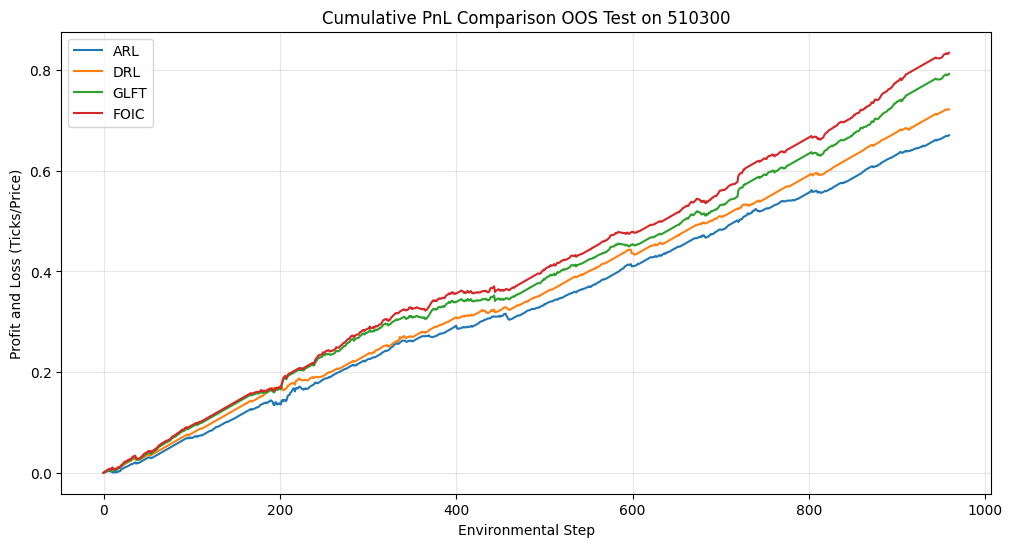

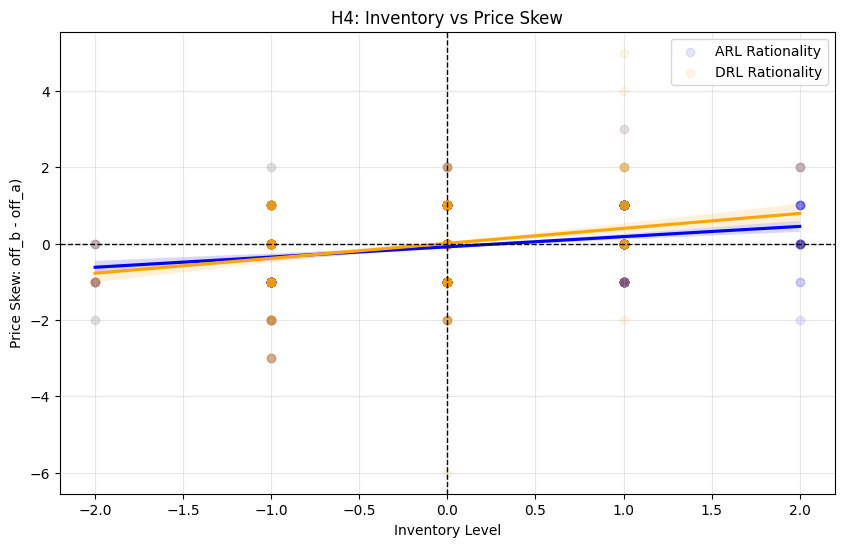

In [10]:
def get_clean_stats(df, name):
    pnl = df['wealth'].iloc[-1] - df['wealth'].iloc[0]
    
    returns = df['wealth'].diff().dropna()
    # Per-step Sharpe
    sharpe = returns.mean() / (returns.std() + 1e-9)
    
    # Maximum Drawdown
    cum_max = df['wealth'].cummax()
    drawdown = df['wealth'] - cum_max
    mdd = drawdown.min()
    
    fills = df['fill_buy'].sum() + df['fill_sell'].sum()
    
    return {
        'Method': name.upper(),
        'Net PnL': round(pnl, 4),
        'Sharpe (Step)': round(sharpe, 4),
        'MDD (Abs)': round(mdd, 4),
        'Total Fills': int(fills)
    }

results = [get_clean_stats(dfs[m], m) for m in methods if m in dfs]
stats_df = pd.DataFrame(results)
print(stats_df.to_string(index=False))

plt.figure(figsize=(12, 6))
for m in methods:
    if m in dfs:
        pnl_series = dfs[m]['wealth'] - dfs[m]['wealth'].iloc[0]
        plt.plot(pnl_series, label=f"{m.upper()}")

plt.title(f"Cumulative PnL Comparison OOS Test on {symbol}")
plt.xlabel("Environmental Step")
plt.ylabel("Profit and Loss (Ticks/Price)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
for m, color in zip(['arl', 'drl'], ['blue', 'orange']):
    if m in dfs:
        sample_df = dfs[m].sample(n=min(3000, len(dfs[m])))
        sns.regplot(data=sample_df, x='inventory', y='skew', 
                    label=f'{m.upper()} Rationality', 
                    scatter_kws={'alpha':0.1, 'color': color}, 
                    line_kws={'color': color})

plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.title("H4: Inventory vs Price Skew")
plt.xlabel("Inventory Level")
plt.ylabel("Price Skew: off_b - off_a)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()